# Practical Assignment 2 - Classifying with Real-world examples
#### Image Adhikari (Roll No: 02)

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

### Loading the Iris dataset

The Iris dataset is one of the first modern examples of statistical classification. It is a collection of morphological measurements of several iris flowers. These measurements will enable us to distinguish multiple species of flower. 

The following four attributes of each plant were measured:
1. Sepal length
2. Sepal width
3. Petal length
4. Petal width

In general, we call the individual numeric measurements we use to describe our data features. These features can be directly measured or computed from intermediate data.

This dataset has four features. Additionally, for each plant, the species is recorded. The problem we want to solve is: "given these examples, if we see a new flower out in the field, could we make a good prediction about its species from its measurements?

This is the classification problem: given labeled examples, can we design a rule to be later applied to other examples?

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

In [3]:
features = data.data
feature_names = data.feature_names

In [4]:
target = data.target
target_names = data.target_names

Using NumPy fancy indexing to get an array of strings:

In [5]:
labels = target_names[target]

Plotting all the features:

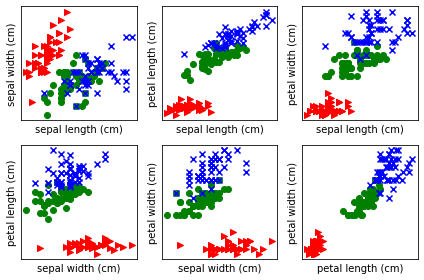

In [6]:
fig,axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
        ('r', '>'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

Each subplot in the above plot shows all points projected into two of the dimensions. The outlying group (triangles) are the Iris Setosa plants, while Iris Versicolor plants are in the center (circle) and Iris Virginica are plotted with x marks.

### Classifying with Decision Tree

If the goal is to separate the three types of flowers, we can immediately make a few suggestions just by looking at the data. For example, petal length seems to be able to separate Iris Setosa from the other two flower species on its own.

We can try to combine multiple rules in a decision tree. This is one of the simplest models for classification and was one of the first models to be proposed for machine learning. It has the further advantage that the model can be simple to interpret.

In [7]:
from sklearn import tree
tr = tree.DecisionTreeClassifier(min_samples_leaf=10) 

In [8]:
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

Plotting the decision tree (using an intermediate file):

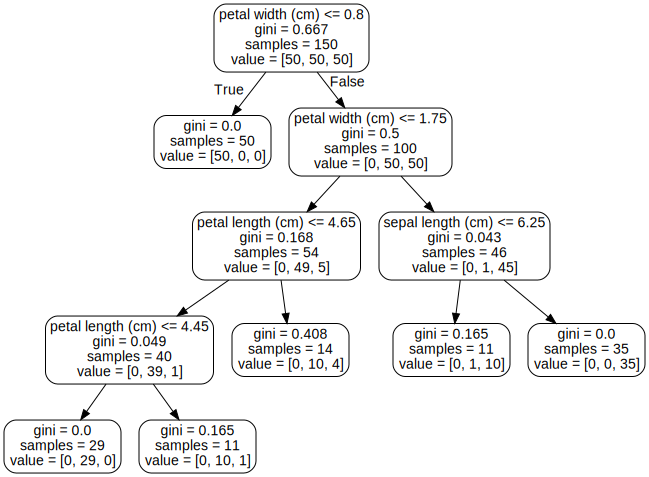

In [9]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file='decision.dot')

graphviz.Source(open('decision.dot').read())

How good is this model? We can try it out by applying it to the data (using the predict method) and seeing how well it matches with the input:

In [10]:
prediction = tr.predict(features)
print("Accuracy: {:.1%}".format(np.mean(prediction == labels)))

Accuracy: 96.0%


We just evaluated performance on the training set (which is not the right way to do it). 

We can achieve a good approximation of this impossible ideal via a method called cross-validation. One simple form of cross-validation is leave-one-out cross-validation. We will take an example out of the training data, learn a model without this example, and then test whether the model classifies this example correctly.

This process is then repeated for all the elements in the dataset:

In [11]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

In [12]:
print("Accuracy (with LOO CV): {:.1%}".format(np.mean(predictions.ravel() == labels)))

Accuracy (with LOO CV): 95.3%


We can do the same leave-on-out cross validation with scikit-learn's model_selection module:

In [13]:
from sklearn import model_selection

predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut())
print(np.mean(predictions == labels))

0.9533333333333334


### More Complex Dataset - The Seeds Dataset

We now look at another agricultural dataset, which is still small, but already too large to plot exhaustively on a page as we did with the Iris dataset. This dataset consists of measurements of wheat seeds. There are seven features that are present, which are as follows:
1. Area A
2. Perimeter P
3. Compactness C = 4πA/P2
4. Length of kernel
5. Width of kernel
6. Asymmetry coefficient
7. Length of kernel groove

There are three classes corresponding to three wheat varieties: Canadian, Koma, and Rosa. As earlier, the goal is to be able to classify the species based on these morphological measurements.

In [14]:
from load import load_dataset

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

### Nearest neighbor classification

For use with this dataset, we will introduce a new classifier: the nearest neighbor classifier. The nearest neighbor classifier is very simple. When classifying a new element, this looks at the training data. For the object that is closest to it, its nearest neighbor. Then, it returns its label as the answer. Notice that this model performs perfectly on its training data! For each point, its closest neighbor is itself, and so its label matches perfectly (unless two examples with different labels have exactly the same feature values, which will indicate that the features you are using are not very descriptive). Therefore, it is essential to test the classification using a cross-validation protocol.

The nearest neighbor method can be generalized to look not at a single neighbor, but to multiple ones, and can take a vote amongst the neighbors. This makes the method more robust than outliers or mislabeled data.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

In [18]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training,testing in kf.split(features):
   # We learn a model for this fold with `fit` and then apply it to the
   # testing data with `predict`:
   knn.fit(features[training], target[training])
   prediction = knn.predict(features[testing])

   # np.mean on an array of booleans returns fraction
 # of correct decisions for this fold:
   curmean = np.mean(prediction == target[testing])
   means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf.split(features):
    # We learn a model for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])

    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 83.8%
Mean accuracy: 86.7%


In [19]:
def plot_decision_space(clf, features, target, use_color=True):
    from matplotlib.colors import ListedColormap

    clf.fit(features[:, [0,2]], target)

    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)
    C = clf.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if use_color:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])

    fig,ax = plt.subplots()
    ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
    for lab, ma in zip(range(3), "Do^"):
        ax.plot(features[target == lab, 0], features[
                 target == lab, 2], ma, c=(1., 1., 1.), ms=6)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    return fig

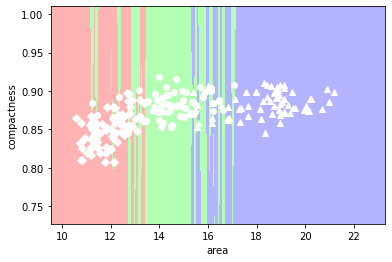

In [20]:
_ = plot_decision_space(knn, features, target)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()),
                       ('knn', classifier)])

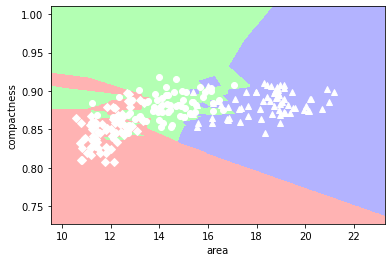

In [22]:
_ = plot_decision_space(classifier, features, target)

### Random Forest Classifier - likely the best (or close to the best) for a majority of problems

A forest is a collection of trees. In this case, a collection of decision trees. 

How do we obtain many trees from a single dataset? If you try to call the methods we used before several times, you will find that you will get the exact same tree every time. The trick is to call the method several times with different random variations of the dataset. In particular, each time, we take a fraction of the dataset and a fraction of the features.
Thus, each time, there is a different tree. At classification time, all the trees vote and a final decision is reached.

In [23]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100)

In [24]:
predict = model_selection.cross_val_predict(rf, features, target)
print("RF accuracy: {:.1%}".format(np.mean(predict == target)))

RF accuracy: 90.0%


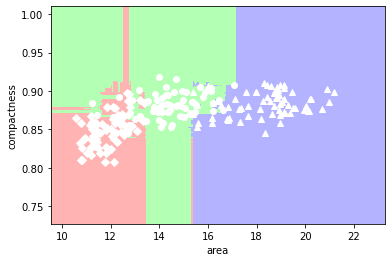

In [25]:
_= plot_decision_space(rf, features, target)

Classification means generalizing from examples to build a model that assigns objects to a predefined class (that is, a rule that can automatically be applied to new, unclassified objects). It is one of the fundamental tools in machine learning.

In this assignment, we learned generic concepts with simple examples. We went over a few operations with the Iris dataset, which is a small dataset. However, it has the advantage that we were able to plot all the data and see what we were doing in detail. This is something that will be lost when we move on to problems with many dimensions and many thousands of examples. The insight we gained here will still be valid.

We also learned that the training error is a misleading, over-optimistic estimate of how well the model does. We must instead evaluate it on testing data that has not been used for training. In order to not waste too many examples in testing, a cross-validation schedule can get us the best of both worlds (at the cost of more computation).

Finally, we discussed what is often the best off-the-shelf classifier, random forests. It's simple to use a classification system that is very flexible (requiring little preprocessing of the data) and achieves very high performance in a wide range of problems.